In [377]:
# -*- coding: utf-8 -*-
# Adapted from 2017 Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
import pandas as pd
from scipy.integrate import solve_ivp

class Rocket:
    GMe = 3.986004418 * 10**14  # Earth gravitational constant [m^3/s^2]
    Re = 6371.0 * 1000  # Earth Radius [m]
    g0 = 9.80665  # Gravitational acceleration on Earth surface [m/s^2]

    def __init__(self):
        self.Vr = np.sqrt(self.GMe / self.Re)  # m/s
        self.H0 = 10.0  # m
        self.V0 = 0.0
        self.M0 = 100000.0  # kg
        self.Mp = self.M0 * 0.99
        self.Cd = 0.6
        self.A = 4.0  # m2
        self.Isp = 400.0  # s
        self.g0 = 9.80665  # m/s2
        self.c  = self.Isp*self.g0 #m/s
        self.Tmax = self.M0 * self.g0 * 1.5
        self.MaxQ = 0.07*10**6  # Pa
        self.MaxG = 8.0  # G
        self.Hmax = 600.0 * 1000  # m
        self.Rmax = self.Re + self.Hmax # m/s
        self.Vmax = np.sqrt(self.GMe / self.Rmax)  # m/s
        self.Vfmax = 10;
        
        self.thetaTarget = np.deg2rad(25)
        self.Htarget = 0 * 1000;
        self.Rtarget = self.Re + self.Htarget;
        
    def air_density(self, h):
        beta = 1/8500.0  # scale factor [1/m]
        rho0 = 1.225  # kg/m3
        return rho0*np.exp(-beta*h)
    
    def dynamic_pressure(self, R, Vr, Vt):
        rho = self.air_density(R-obj.Re)
        
        q = 0.5 * rho * (Vr**2 + Vt**2)
        
        return q
    
    def passive_rocket_dynamics(self, t, x):
        R     = x[0]
        theta = x[1]
        Vr    = x[2]
        Vt    = x[3]
        m     = x[4]

        rho = self.air_density(R - self.Re)
        Dr = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
            * self.Cd * self.A  # [N]
        Dt = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
            * self.Cd * self.A  # [N]
        g = self.g0 * (self.Re / R)**2  # [m/s2]
        g0 = self.g0
        Isp = self.Isp

        dx = np.zeros(5)
        dx[0] = Vr
        dx[1] = Vt / R
        dx[2] = - Dr / m - g + Vt**2 / R
        dx[3] = - Dt / m - (Vr * Vt) / R
        dx[4] = 0

        return dx
    
    def hits_ground(self, t, x):
        R = x[0]
        return R-self.Re
    
    hits_ground.terminal = True


def dynamics(prob, obj, section):
    R     = prob.states(0, section)
    theta = prob.states(1, section)
    Vr    = prob.states(2, section)
    Vt    = prob.states(3, section)
    m     = prob.states(4, section)
    Tr    = prob.controls(0, section)
    Tt    = prob.controls(1, section)

    rho = obj.air_density(R - obj.Re)
    Dr = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    Dt = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    g = obj.g0 * (obj.Re / R)**2  # [m/s2]
    g0 = obj.g0
    Isp = obj.Isp

    dx = Dynamics(prob, section)
    dx[0] = Vr
    dx[1] = Vt / R
    dx[2] = Tr / m - Dr / m - g + Vt**2 / R
    dx[3] = Tt / m - Dt / m - (Vr * Vt) / R
    dx[4] = - np.sqrt(Tr**2 + Tt**2) / obj.c

    return dx()


def equality(prob, obj):
    R     = prob.states_all_section(0)
    theta = prob.states_all_section(1)
    Vr    = prob.states_all_section(2)
    Vt    = prob.states_all_section(3)
    m     = prob.states_all_section(4)
    Tr    = prob.controls_all_section(0)
    Tt    = prob.controls_all_section(1)
    tf    = prob.time_final(-1)

    result = Condition()

    # event condition
    result.equal(R[0], obj.Re)
    result.equal(theta[0], 0)
    result.equal(Vr[0], 0)
    result.equal(Vt[0], 0)
    result.equal(m[0], obj.M0)
    
    #result.add(R[0] - obj.Re,  unit=prob.unit_states[0][0])
    #result.add(theta[0] - 0.0, unit=prob.unit_states[0][1])
    #result.add(Vr[0] - 0.0,    unit=prob.unit_states[0][2])
    #result.add(Vt[0] - 0.0,    unit=prob.unit_states[0][3])
    #result.add(m[0] - obj.M0,  unit=prob.unit_states[0][4])
    
    result.equal(R[-1], obj.Rtarget)
    #result.equal(theta[-1], obj.thetaTarget)
    
    
    #result.add(R[-1] - 0,    unit=prob.unit_states[0][0])
    #result.add(theta[-1] - obj.thetaTarget, unit=prob.unit_states[0][1])
    #result.add(Vr[-1] - 0.0, unit=prob.unit_states[0][2])
    #result.add(Vt[-1] - 0,   unit=prob.unit_states[0][3])


    return result()


def inequality(prob, obj):
    R     = prob.states_all_section(0)
    theta = prob.states_all_section(1)
    Vr    = prob.states_all_section(2)
    Vt    = prob.states_all_section(3)
    m     = prob.states_all_section(4)
    Tr    = prob.controls_all_section(0)
    Tt    = prob.controls_all_section(1)
    tf    = prob.time_final(-1)

    rho = obj.air_density(R - obj.Re)
    Dr = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    Dt = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
        * obj.Cd * obj.A  # [N]
    g = obj.g0 * (obj.Re / R)**2  # [m/s2]

    # dynamic pressure
    q = 0.5 * rho * (Vr**2 + Vt**2)  # [Pa]
    # accelaration
    a_r = (Tr - Dr) / m
    a_t = (Tt - Dt) / m
    a_mag = np.sqrt(a_r**2 + a_t**2)  # [m/s2]
    # Thrust
    T = np.sqrt(Tr**2 + Tt**2)

    result = Condition()

    # lower bounds
    result.lower_bound(R,obj.Re)
    result.lower_bound(m,obj.M0 - obj.Mp)
    result.lower_bound(theta[-1], obj.thetaTarget)
    # result.add(Vr - 0.0, unit=prob.unit_states[0][2])
    # result.add(Vt - 0.0, unit=prob.unit_states[0][3])
    
    #result.add(Tr - 0.0, unit=prob.unit_controls[0][0])
    # result.add(Tt + obj.Tmax / obj.unit_T, unit=prob.unit_controls[0][0])
    #result.add(Tt - 0.0, unit=prob.unit_controls[0][0])

    # upper bounds
    result.upper_bound(m,obj.M0)
    result.upper_bound(R, obj.Rmax)
    #result.add(obj.Tmax - Tr, unit=prob.unit_controls[0][0])
    #result.add(obj.Tmax - Tt, unit=prob.unit_controls[0][0])
    result.upper_bound(T,obj.Tmax)
    # result.add(obj.MaxQ - q, unit = prob.unit_states[0][0])
    #result.add(obj.MaxG * obj.g0 - a_mag)
    
    result.upper_bound(abs(Vr[-1]), 100)
    result.upper_bound(abs(Vt[-1]), 100)
    result.upper_bound(Vr[-1]**2 + Vt[-1]**2 , obj.Vfmax**2)
    result.upper_bound(Vr**2 + Vt**2, 5000**2)

    result.upper_bound(q, obj.MaxQ)
    return result()


def cost(prob, obj):
    m = prob.states_all_section(4)
    # return -m[-1]
    # ==== Caution ====
    # cost function should be near 1.0
    return -m[-1] / prob.unit_states[0][4]


def cost_derivative(prob, obj):
    jac = Condition(prob.number_of_variables)
    index_m0 = prob.index_states(4, 0, 0)
    index_mf = prob.index_states(4, 0, -1)
    m = prob.states_all_section(4)
    # jac.change_value(index_m0, - m[-1] / m[0]**2)
    # jac.change_value(index_mf, - 1.0 / m[0])
    jac.change_value(index_mf, - 1.0)
    return jac()


In [378]:

# ========================
# plt.close("all")
plt.ion()
# Program Starting Point
time_init = [0.0, 850]
n = [40]
num_states = [5]
num_controls = [2]
max_iteration = 10

flag_savefig = False
savefig_file = "08_Rocket_Ascent_Polar/SSTO_"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)

# ------------------------
# create instance of operating object
obj = Rocket()

unit_R = obj.Re
unit_theta = 1
unit_V = np.sqrt(obj.GMe / obj.Re)
unit_m = obj.M0
unit_t = unit_R / unit_V
unit_T = unit_m * unit_R / unit_t ** 2

prob.set_unit_states_all_section(0, unit_R)
prob.set_unit_states_all_section(1, unit_theta)
prob.set_unit_states_all_section(2, unit_V)
prob.set_unit_states_all_section(3, unit_V)
prob.set_unit_states_all_section(4, unit_m)
prob.set_unit_controls_all_section(0, unit_T)
prob.set_unit_controls_all_section(1, unit_T)
prob.set_unit_time(unit_t)



In [379]:
#solve for guess using no drag, and impulsive thrust
th = obj.thetaTarget/2 #half angle of transfer

a = obj.Re/2*(1+np.sin(th)) #semi major axis
b = obj.Re/2*np.sqrt(2*(np.sin(th)+np.sin(th)**2)) #semi major axis
c = np.sqrt(a**2-b**2)

#assume y varies linearly
N = len(prob.time_all_section)
t_g = np.linspace(time_init[0],time_init[-1],N)
y_g = np.linspace(obj.Re*np.sin(th),-obj.Re*np.sin(th),N)

#solve for x
x_g = a*np.sqrt(1-(y_g/b)**2)

#solve for r, theta and rotate appropriately
r_g = np.sqrt((c+x_g)**2+y_g**2)+10
theta_g = -np.arctan2(y_g,(x_g+c)) + th #rotate it such that it starts at 0 and goes to the target theta

#plot
#plt.polar(theta_g,r_g)

In [380]:
delta_t = t_g[1]-t_g[0]
vr_g = np.gradient(r_g,delta_t)
vt_g = np.gradient(theta_g, delta_t)*r_g

delta_v_no_drag = np.sqrt(2*obj.g0*obj.Re*np.sin(th)/(1+np.sin(th)))
burn_time = delta_v_no_drag/(obj.Tmax/obj.M0)

Tr_g = np.zeros_like(t_g)
Tr_g[t_g<burn_time] = obj.Tmax/3
Tr_g[t_g>t_g[-1]-burn_time] = obj.Tmax/3

Tt_g = np.zeros_like(Tr_g)
Tt_g[t_g <   t_g[-1]/3] =  obj.Tmax/10
Tt_g[t_g > 2*t_g[-1]/3] = -obj.Tmax/10

T_g = np.sqrt(Tr_g**2+Tt_g**2)

m_g = obj.M0 - np.cumsum(T_g)*delta_t/obj.c

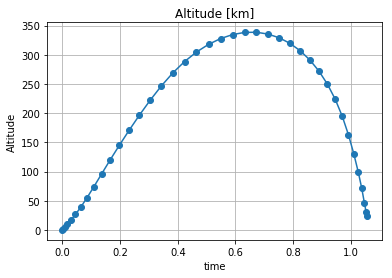

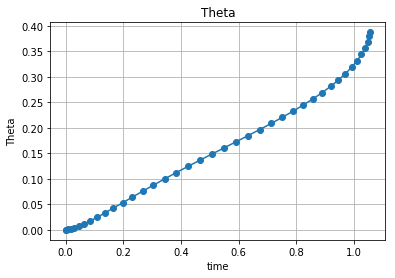

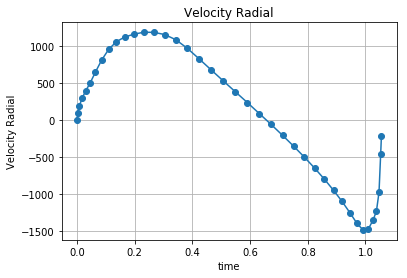

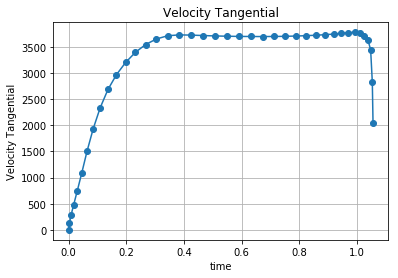

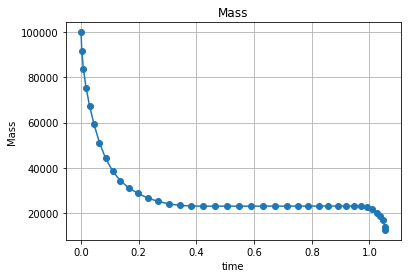

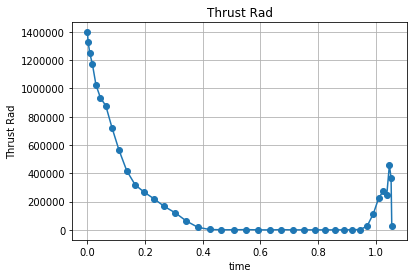

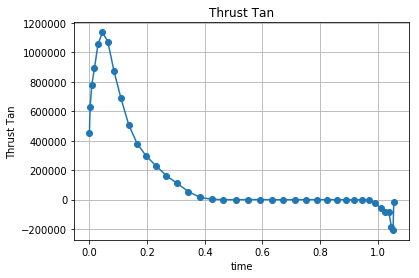

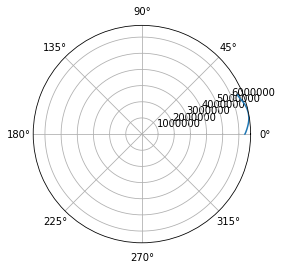

In [381]:
if 0:
    # ========================
    # Initial parameter guess

    # altitude profile
    R_init = Guess.cubic(prob.time_all_section, obj.Re, 100000, obj.Re, -100000)
    
    # if(flag_savefig):plt.savefig(savefig_file + "guess_alt" + ".png")
    # theta
    theta_init = Guess.cubic(prob.time_all_section, 0.0, 0.0, obj.thetaTarget, 0.0)
    

    # velocity
    Vr_init = Guess.cubic(prob.time_all_section, 0.0,10000, 0.0,10000)
    Vt_init = Guess.cubic(prob.time_all_section, 0,1000,0,1000)
    
    # mass profile
    M_init = Guess.cubic(prob.time_all_section, obj.M0, -0.6, obj.M0-obj.Mp, 0.0)
    


    # thrust profile
    # T_init = Guess.zeros(prob.time_all_section)
    #Tr_init = Guess.cubic(prob.time_all_section, obj.Tmax/2, 0.0, obj.Tmax/2, 4000000)
    Tr_init = Guess.linear(prob.time_all_section, 0,0)
    #Tt_init = Guess.cubic(prob.time_all_section, obj.Tmax/2, 0.0, 0.0, 0.0)
    Tt_init = Guess.linear(prob.time_all_section, 0,0)


    plt.show()
else:
    R_init = r_g
    theta_init = theta_g
    Vr_init = vr_g
    Vt_init = vt_g
    M_init = m_g
    Tr_init = Tr_g
    Tt_init = Tt_g
    
if 1: #load from csv
    t = np.linspace(time_init[0], time_init[1], n[0])
    df = pd.read_csv('OpenGoddard_output.csv')
    R_init     = np.interp(t, df["# time"],df[" state0"]) 
    theta_init = np.interp(t, df["# time"],df[" state1"])
    Vr_init    = np.interp(t, df["# time"],df[" state2"])
    Vt_init    = np.interp(t, df["# time"],df[" state3"])
    M_init     = np.interp(t, df["# time"],df[" state4"])
    
    Tr_init    = np.interp(t, df["# time"],df[" control0"])
    Tt_init    = np.interp(t, df["# time"],df[" control1"])
    
    
Guess.plot(prob.time_all_section, (R_init-obj.Re)/1000, "Altitude [km]", "time", "Altitude")
Guess.plot(prob.time_all_section, theta_init, "Theta", "time", "Theta")
Guess.plot(prob.time_all_section, Vr_init, "Velocity Radial", "time", "Velocity Radial")
Guess.plot(prob.time_all_section, Vt_init, "Velocity Tangential", "time", "Velocity Tangential")
Guess.plot(prob.time_all_section, M_init, "Mass", "time", "Mass")
Guess.plot(prob.time_all_section, Tr_init, "Thrust Rad", "time", "Thrust Rad")
Guess.plot(prob.time_all_section, Tt_init, "Thrust Tan", "time", "Thrust Tan")

plt.figure()
plt.polar(theta_init,R_init)

In [382]:

# ========================
# Substitution initial value to parameter vector to be optimized
# non dimensional values (Divide by scale factor)
prob.set_states_all_section(0, R_init)
prob.set_states_all_section(1, theta_init)
prob.set_states_all_section(2, Vr_init)
prob.set_states_all_section(3, Vt_init)
prob.set_states_all_section(4, M_init)
prob.set_controls_all_section(0, Tr_init)
prob.set_controls_all_section(1, Tt_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
# prob.cost_derivative = cost_derivative
prob.equality = equality
prob.inequality = inequality


def display_func():
    R = prob.states_all_section(0)
    theta = prob.states_all_section(1)
    Vr = prob.states_all_section(2)
    Vt = prob.states_all_section(3)
    m = prob.states_all_section(4)
    
    q = obj.dynamic_pressure(R,Vr,Vt)
    
    tf = prob.time_final(-1)
    print("m0          : {0:.5f}".format(m[0]))
    print("mf          : {0:.5f}".format(m[-1]))
    print("max altitude: {0:.5f}".format(max(R-obj.Re)))
    print("max q       : {0:.5f}".format(max(q)))
    print("max angle   : {0:.5f}".format(max(theta)))
    print("final time  : {0:.3f}".format(tf))

prob.solve(obj, display_func, ftol=1e-5)


---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.06622975032922024
            Iterations: 26
            Function evaluations: 7372
            Gradient evaluations: 26
Iteration limit exceeded
m0          : 100000.00000
mf          : 6622.97503
max altitude: 378721.63455
max q       : 70048.10217
max angle   : 0.43633
final time  : 1026.397

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.07901542004403951
            Iterations: 26
            Function evaluations: 7379
            Gradient evaluations: 26
Iteration limit exceeded
m0          : 100000.00000
mf          : 7901.54200
max altitude: 493966.00993
max q       : 70003.61322
max angle   : 0.43633
final time  : 1031.544

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.07942474482291019
            Iterations: 26
            Function evaluations: 7412
       

In [383]:
# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
R     = prob.states_all_section(0)
theta = prob.states_all_section(1)
Vr    = prob.states_all_section(2)
Vt    = prob.states_all_section(3)
m     = prob.states_all_section(4)
Tr    = prob.controls_all_section(0)
Tt    = prob.controls_all_section(1)
time  = prob.time_update()

# ------------------------
# Calculate necessary variables
rho = obj.air_density(R - obj.Re)
Dr  = 0.5 * rho * Vr * np.sqrt(Vr**2 + Vt**2) \
    * obj.Cd * obj.A  # [N]
Dt  = 0.5 * rho * Vt * np.sqrt(Vr**2 + Vt**2) \
    * obj.Cd * obj.A  # [N]
g   = obj.g0 * (obj.Re / R)**2  # [m/s2]

# dynamic pressure
q   = 0.5 * rho * (Vr**2 + Vt**2)  # [Pa]
# accelaration
a_r = (Tr - Dr) / m
a_t = (Tt - Dt) / m
a_mag = np.sqrt(a_r**2 + a_t**2)  # [m/s2]
# Thrust
T   = np.sqrt(Tr**2 + Tt**2)




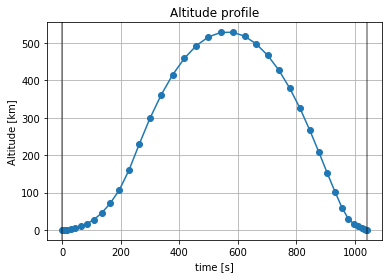

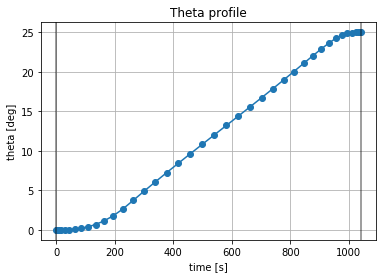

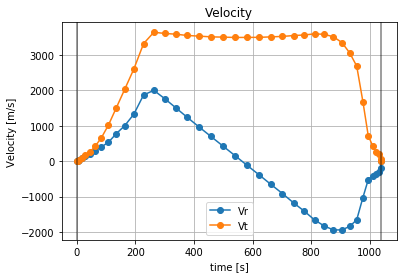

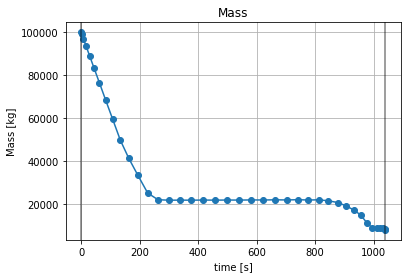

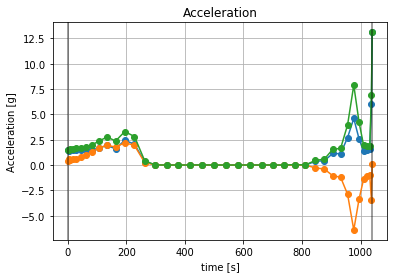

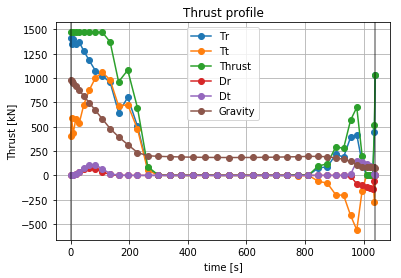

In [384]:
# ------------------------
# Visualizetion
plt.figure()
plt.title("Altitude profile")
plt.plot(time, (R - obj.Re)/1000, marker="o", label="Altitude")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [km]")
if(flag_savefig): plt.savefig(savefig_file + "altitude" + ".png")
    
plt.figure()
plt.title("Theta profile")
plt.plot(time, np.rad2deg(theta), marker="o", label="Theta")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("theta [deg]")
if(flag_savefig): plt.savefig(savefig_file + "theta" + ".png")

plt.figure()
plt.title("Velocity")
plt.plot(time, Vr, marker="o", label="Vr")
plt.plot(time, Vt, marker="o", label="Vt")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [m/s]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "velocity" + ".png")

plt.figure()
plt.title("Mass")
plt.plot(time, m, marker="o", label="Mass")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [kg]")
if(flag_savefig): plt.savefig(savefig_file + "mass" + ".png")

plt.figure()
plt.title("Acceleration")
plt.plot(time, a_r/obj.g0, marker="o", label="Acc r")
plt.plot(time, a_t/obj.g0, marker="o", label="Acc t")
plt.plot(time, a_mag/obj.g0, marker="o", label="Acc")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Acceleration [g]")
if(flag_savefig): plt.savefig(savefig_file + "acceleration" + ".png")

plt.figure()
plt.title("Thrust profile")
plt.plot(time, Tr / 1000, marker="o", label="Tr")
plt.plot(time, Tt / 1000, marker="o", label="Tt")
plt.plot(time, T / 1000, marker="o", label="Thrust")
plt.plot(time, Dr / 1000, marker="o", label="Dr")
plt.plot(time, Dt / 1000, marker="o", label="Dt")
plt.plot(time, m * g / 1000, marker="o", label="Gravity")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [kN]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "force" + ".png")

plt.show()

In [385]:
if 0:
    prob.to_csv()

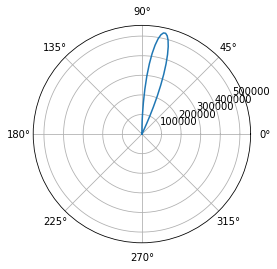

In [386]:
plt.polar(-theta+np.pi/2,R-obj.Re)

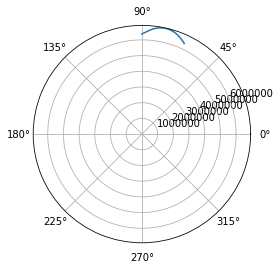

In [387]:
plt.polar(-theta+np.pi/2,R)

In [388]:
print('Dry Mass Fraction: {}'.format(m[0]/m[-1]))
print('Transfer Time:     {} mins'.format(time[-1]/60))

Dry Mass Fraction: 12.414317708319361
Transfer Time:     17.328936538469552 mins


In [389]:
yf = [R[-1], theta[-1],Vr[-1],Vt[-1],m[-1]]
tf = time[-1]

In [390]:
y_passive = solve_ivp(fun=obj.passive_rocket_dynamics, t_span=(tf, 2*tf), y0=yf, events=obj.hits_ground)

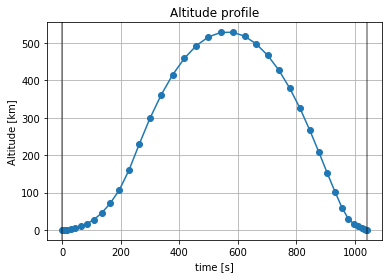

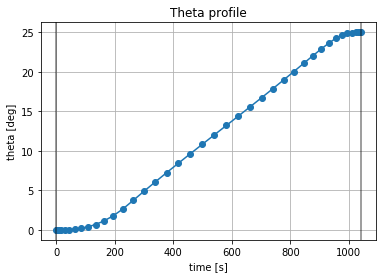

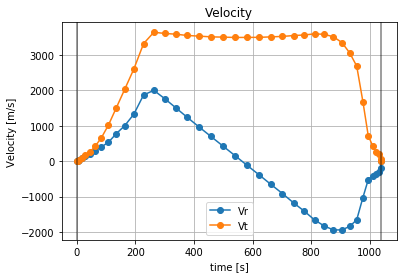

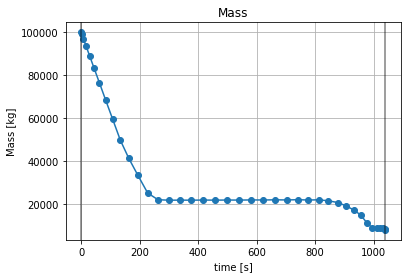

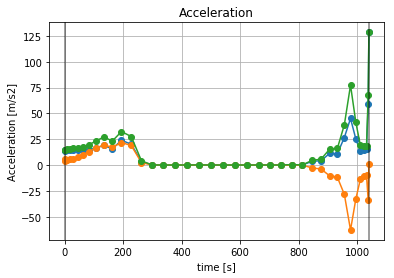

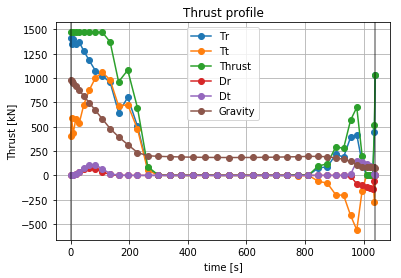

In [391]:
# ------------------------
# Visualizetion
plt.figure()
plt.title("Altitude profile")
plt.plot(time, (R - obj.Re)/1000, marker="o", label="Altitude")
plt.plot(y_passive.t,(y_passive.y[0]-obj.Re)/1000)
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [km]")
if(flag_savefig): plt.savefig(savefig_file + "altitude" + ".png")
    
plt.figure()
plt.title("Theta profile")
plt.plot(time, np.rad2deg(theta), marker="o", label="Theta")
plt.plot(y_passive.t, np.rad2deg(y_passive.y[1]))
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("theta [deg]")
if(flag_savefig): plt.savefig(savefig_file + "theta" + ".png")

plt.figure()
plt.title("Velocity")
plt.plot(time, Vr, marker="o", label="Vr")
plt.plot(time, Vt, marker="o", label="Vt")
plt.plot(y_passive.t, (y_passive.y[2]))
plt.plot(y_passive.t, (y_passive.y[3]))
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [m/s]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "velocity" + ".png")

plt.figure()
plt.title("Mass")
plt.plot(time, m, marker="o", label="Mass")
plt.plot(y_passive.t, (y_passive.y[4]))
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [kg]")
if(flag_savefig): plt.savefig(savefig_file + "mass" + ".png")

plt.figure()
plt.title("Acceleration")
plt.plot(time, a_r, marker="o", label="Acc r")
plt.plot(time, a_t, marker="o", label="Acc t")
plt.plot(time, a_mag, marker="o", label="Acc")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Acceleration [m/s2]")
if(flag_savefig): plt.savefig(savefig_file + "acceleration" + ".png")

plt.figure()
plt.title("Thrust profile")
plt.plot(time, Tr / 1000, marker="o", label="Tr")
plt.plot(time, Tt / 1000, marker="o", label="Tt")
plt.plot(time, T / 1000, marker="o", label="Thrust")
plt.plot(time, Dr / 1000, marker="o", label="Dr")
plt.plot(time, Dt / 1000, marker="o", label="Dt")
plt.plot(time, m * g / 1000, marker="o", label="Gravity")
for line in prob.time_knots():
    plt.axvline(line, color="k", alpha=0.5)
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [kN]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "force" + ".png")

plt.show()

In [392]:
time_full = np.concatenate((time,y_passive.t))
R_full = np.concatenate((R,y_passive.y[0]))
theta_full = np.concatenate((theta,y_passive.y[1]))
Vr_full = np.concatenate((Vr,y_passive.y[2]))
Vt_full = np.concatenate((Vt,y_passive.y[3]))
m_full = np.concatenate((m,y_passive.y[4]))


Text(0,0.5,'Altitude (km)')

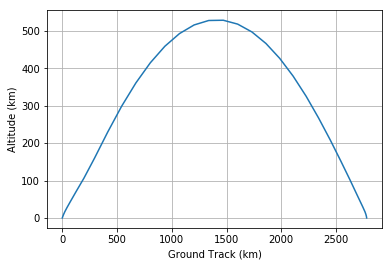

In [393]:
plt.plot(theta_full*obj.Re/1000,(R_full-obj.Re)/1000)
plt.grid(True)
plt.xlabel('Ground Track (km)')
plt.ylabel('Altitude (km)')

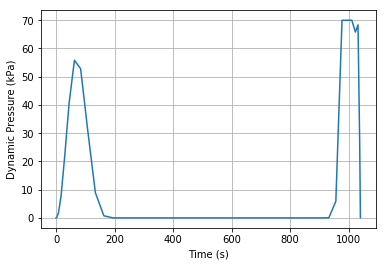

In [394]:
plt.plot(time_full,obj.dynamic_pressure(R_full, Vr_full, Vt_full)/1000)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel('Dynamic Pressure (kPa)');

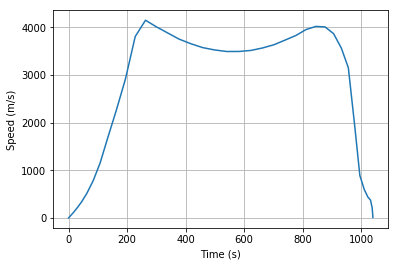

In [395]:
plt.plot(time, np.sqrt(Vr**2 + Vt**2))
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.grid(True)

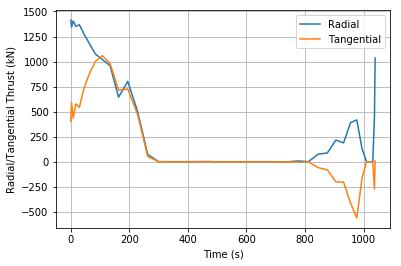

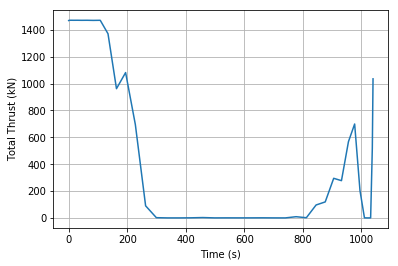

In [396]:
plt.figure()
plt.plot(time,Tr/1000,label="Radial")
plt.plot(time,Tt/1000,label="Tangential")
plt.xlabel('Time (s)')
plt.ylabel('Radial/Tangential Thrust (kN)')
plt.grid(True)
plt.legend()




plt.figure()
plt.plot(time,np.sqrt(Tt**2+Tr**2)/1000)
plt.xlabel('Time (s)')
plt.ylabel('Total Thrust (kN)')
plt.grid(True)

In [397]:
dv = obj.c * np.log(m[0]/m)

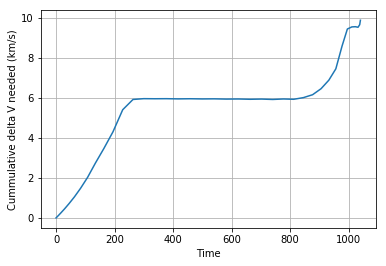

In [398]:
plt.plot(time,dv/1000)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Cummulative delta V needed (km/s)');